In [64]:
import pandas as pd
import pymysql as mc 
import os
import sys
import time
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
import getpass
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 10.0)

In [78]:
pw = getpass.getpass()
cnx = mc.connect(user='akashgoyal',password=pw,
                 host='stromberg.cs.uchicago.edu',db='mlb_practicum',port=3306)

········


In [80]:
query = """SELECT Game.gameID AS gameID,homeTeamScore,awayTeamScore,
                        (trc1.100_avg - trc2.100_avg) AS home_less_away_100, 
                        (trc1.300_avg-trc2.300_avg) AS home_less_away_300,
                        (trc1.500_avg-trc2.500_avg) AS home_less_away_500, 
                        (trc1.1000_avg-trc2.1000_avg) AS home_less_away_1000,
                        pre_h.300_avg-pre_a.300_avg AS home_less_away_300_pitchers,
                        pre_h.500_avg-pre_a.500_avg AS home_less_away_500_pitchers,
                        pre_h.1000_avg-pre_a.1000_avg AS home_less_away_1000_pitchers,
                        pre_h.2000_avg-pre_a.2000_avg AS home_less_away_2000_pitchers,
                        (home10-away10) AS home_less_away_pythag_10,
                        (home30-away30) AS home_less_away_pythag_30,
                        (home50-away50) AS home_less_away_pythag_50,
                        (home100-away100) AS home_less_away_pythag_100
                    
                        FROM Game
                        INNER JOIN team_starting_wrc_stats trc1 ON 
                        (trc1.gameID = Game.gameID AND trc1.retrosheet = Game.homeTeam) 
                        INNER JOIN team_starting_wrc_stats trc2 ON 
                        (trc2.gameID = Game.gameID AND trc2.retrosheet = Game.awayTeam)
                        INNER JOIN Pythagorean_Wins pwins ON pwins.gameID = Game.gameID 
                        INNER JOIN Starting_Pitchers sp ON sp.gameID = Game.gameID 
                        INNER JOIN rs_mlbam_id_map rs_a ON rs_a.retrosheetID = sp.awayPitcher
                        INNER JOIN rs_mlbam_id_map rs_h ON rs_h.retrosheetID = sp.homePitcher 
                        INNER JOIN Pitcher_Run_Expectancy pre_a ON 
                        (pre_a.playerID = rs_a.mlbID AND pre_a.gameID = Game.gameID)
                        INNER JOIN Pitcher_Run_Expectancy pre_h ON 
                        (pre_h.playerID = rs_h.mlbID AND pre_h.gameID = Game.gameID)
                        WHERE YEAR(gameDate)>2010
                        """
df = pd.read_sql_query(query,cnx)

In [130]:
df2 = df.copy()

In [131]:
df2['Y'] = (df2['homeTeamScore']>df2['awayTeamScore']).astype(int)
df2 = df2.drop(columns=['homeTeamScore','awayTeamScore'])
df2 = shuffle(df2)
X = df2.iloc[:,1:-1]
poly1 = PolynomialFeatures(interaction_only=True,include_bias=False)
X = poly1.fit_transform(X)
Y = df2.iloc[:,-1]
qty =int(2*len(df2)/3)

train_x = X[:qty]
train_y = Y[:qty]

In [134]:
lgt = LogisticRegression(penalty='l1',C=2)
lgt.fit(train_x,train_y)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
df3 = df.copy()
df3['Y'] = (df3['homeTeamScore']>df3['awayTeamScore']).astype(int)
df3 = df3.drop(columns=['homeTeamScore','awayTeamScore'])
poly2 = PolynomialFeatures(interaction_only=True,include_bias=False)
X = df3.iloc[:,1:-1]
X = poly2.fit_transform(X)
Y = df3.iloc[:,-1]

In [143]:
lgt.predict_proba(X).shape

(16982, 2)

In [161]:
gameID = df3['gameID']
predictions = lgt.predict_proba(X)
var_1 = predictions[:,0]
var_2 = predictions[:,1]
temp = np.vstack((gameID,var_1,var_2)).transpose()
output_df = pd.DataFrame(temp,columns=['gameID','away_probability','home_probability'])
output_df.to_csv('prior_win_probabilities.csv')

In [85]:
lgt_params = {'C':[0.25,0.50,0.75,1.0,1.25,1.5,1.75,2.0,5,10],'penalty':['l1']}
lgt = LogisticRegression()
clf = GridSearchCV(lgt,lgt_params,cv=5)
clf.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5, 10], 'penalty': ['l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
lgt_params = {'C':[0.25,0.50,0.75,1.0,1.25,1.5,1.75,2.0,5,10],'penalty':['l2']}
lgt = LogisticRegression()
clf2 = GridSearchCV(lgt,lgt_params,cv=5)
clf2.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5, 10], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


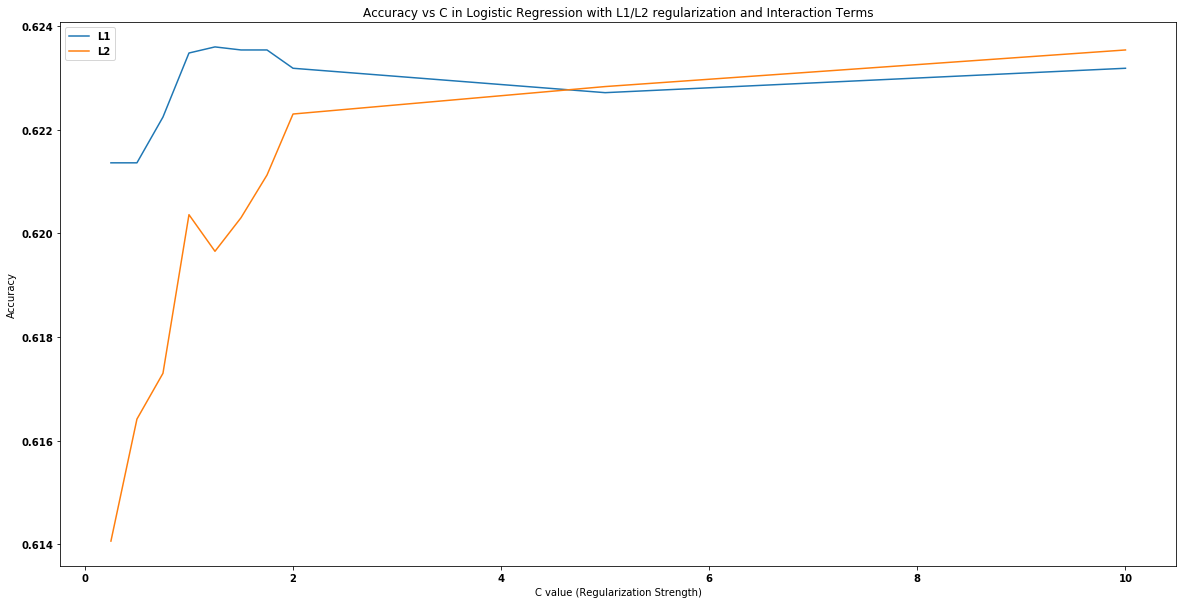

<Figure size 1440x720 with 0 Axes>

In [87]:
Y_l1 = clf.cv_results_['mean_test_score']
Y_l2 = clf2.cv_results_['mean_test_score']
X = [0.25,0.50,0.75,1.0,1.25,1.5,1.75,2.0,5,10]
plt.plot(X,Y_l1,label='L1')
plt.plot(X,Y_l2,label='L2')
plt.xlabel('C value (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C in Logistic Regression with L1/L2 regularization and Interaction Terms')
plt.legend(loc='best')
plt.show()
plt.savefig('logistic_regression_prior_win_probabilities.png')

In [41]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)

In [61]:
sizes = [(i,) for i in range(2,21,2)]
nn_params = {'hidden_layer_sizes':sizes}
nn = MLPClassifier()
clf3 = GridSearchCV(nn,nn_params,cv=3)
clf3.fit(X,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,), (18,), (20,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
sizes = [(i,) for i in range(2,21,2)]
nn_params = {'hidden_layer_sizes':sizes}
nn = MLPClassifier()
clf4 = GridSearchCV(nn,nn_params,cv=3)
clf4.fit(X_poly,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,), (18,), (20,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
sizes = [(i,) for i in range(2,21,2)]
nn_params = {'hidden_layer_sizes':sizes}
nn = MLPRegressor()
clf5 = GridSearchCV(nn,nn_params,cv=3)
clf5.fit(X,Y)
nn2 = MLPRegressor()
clf6 = GridSearchCV(nn2,nn_params,cv=3)
clf6.fit(X_poly,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,), (18,), (20,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


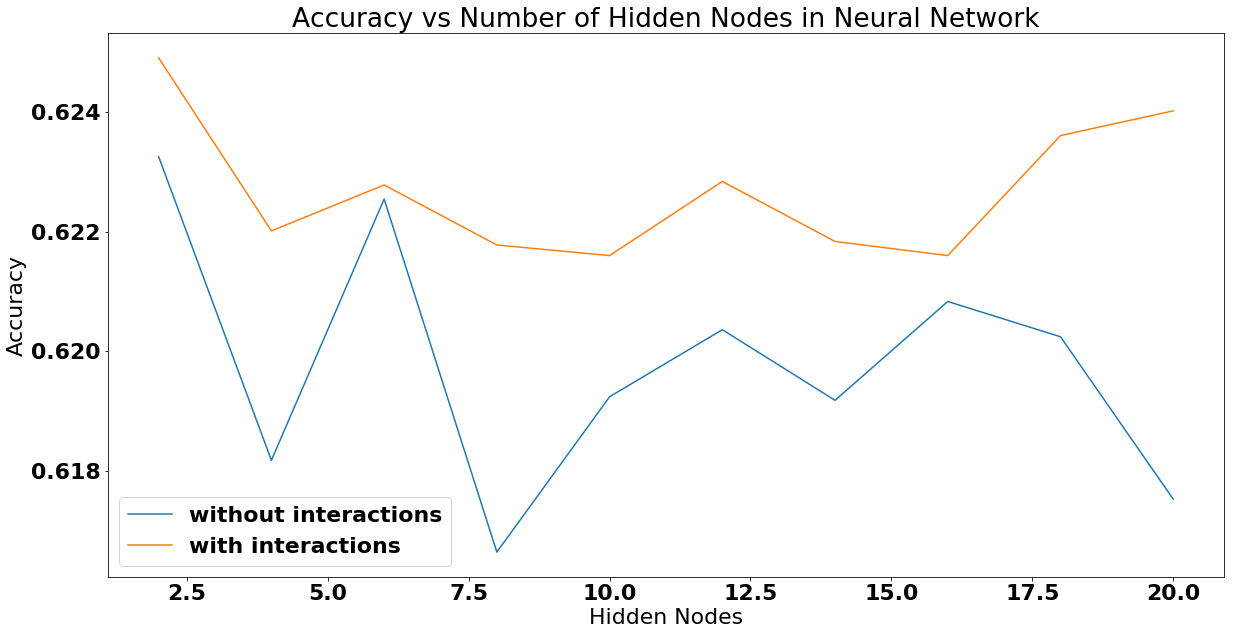

<Figure size 1440x720 with 0 Axes>

In [63]:
#for the neural net
Y_new = clf3.cv_results_['mean_test_score']
Y_poly = clf4.cv_results_['mean_test_score']
X_new = range(2,21,2)
plt.plot(X_new,Y_new,label='without interactions')
plt.plot(X_new,Y_poly,label='with interactions')
plt.xlabel('Hidden Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Hidden Nodes in Neural Network')
plt.legend(loc='best')
plt.show()
plt.savefig('neural_network_prior_win_probabilities.png')

In [93]:
lgt = LogisticRegression(penalty='l1',C=1.0)
lgt.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
for i in range(len(X.columns.values[0])):
    print (X.columns.values[i],lgt.coef_[0][i])

home_less_away_100 14.727009150827882
home_less_away_300 -2.913097864085399
home_less_away_500 0.0
home_less_away_1000 0.0
home_less_away_300_pitchers -11.431494360027543
home_less_away_500_pitchers -0.22420930682895926
home_less_away_1000_pitchers 0.0
home_less_away_2000_pitchers -0.13954970618921947
home_less_away_pythag_10 -0.11278462400035418
home_less_away_pythag_30 -1.0576142736801755
home_less_away_pythag_50 -0.3166304017453424
home_less_away_pythag_100 1.067687484701359


IndexError: index 12 is out of bounds for axis 0 with size 12

In [95]:
lgt.intercept_

array([0.13882628])

In [121]:
new_x = X[['home_less_away_100']]
new_x.head()

,home_less_away_100
11906,-0.014781
15047,0.000930
11579,-0.010124
15718,0.016066
10035,-0.040384


In [122]:
lgt2 = LogisticRegression(penalty='l1')
lgt2.fit(new_x,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
lgt2.score(new_x,Y)

0.5651866682369567